# Imports

In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torch.optim.lr_scheduler as lr_scheduler

# Directiry Setup

In [3]:
drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My MacBook Pro/Mega/Master Studies/Studying/Introduction to Deep Learning (18786)/Mini project/Miniproject')

Mounted at /content/drive


# Load Data

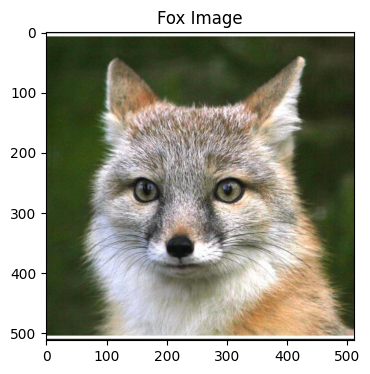

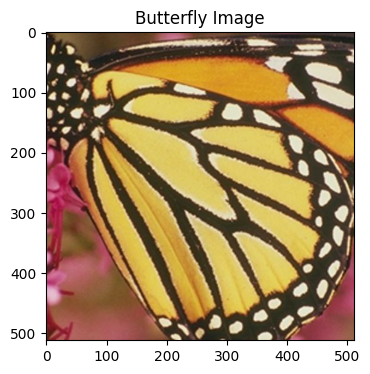

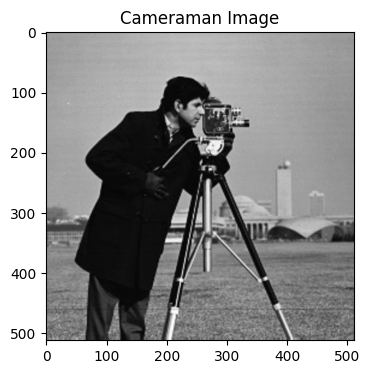

In [8]:
image_fox = plt.imread('data/image/fox.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_fox)
plt.title('Fox Image')
plt.show()

image_butterfly = plt.imread('data/image/butterfly.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_butterfly)
plt.title('Butterfly Image')
plt.show()

image_man = plt.imread('data/image/cameraman.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Cameraman Image')
plt.show()

# Process Fox image

## Prepare input and output data

In [ ]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
X = torch.from_numpy(X) # to tensor

## Output labels
y = image_fox.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Define network

In [ ]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

## Train and Test

In [ ]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=2, output_dim=y.shape[-1]).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-19-4ed5105f11f7>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-19-4ed5105f11f7>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)


Epoch [1/1000], Loss: 0.0815, PSNR: 10.8866, SSIM: 0.4843
Epoch [2/1000], Loss: 0.0785, PSNR: 11.0500, SSIM: 0.4985
Epoch [3/1000], Loss: 0.0745, PSNR: 11.2792, SSIM: 0.5011
Epoch [4/1000], Loss: 0.0711, PSNR: 11.4793, SSIM: 0.5022
Epoch [5/1000], Loss: 0.0671, PSNR: 11.7339, SSIM: 0.5111
Epoch [6/1000], Loss: 0.0634, PSNR: 11.9811, SSIM: 0.5289
Epoch [7/1000], Loss: 0.0617, PSNR: 12.0987, SSIM: 0.5328
Epoch [8/1000], Loss: 0.0613, PSNR: 12.1251, SSIM: 0.5557
Epoch [9/1000], Loss: 0.0597, PSNR: 12.2387, SSIM: 0.5469
Epoch [10/1000], Loss: 0.0575, PSNR: 12.4062, SSIM: 0.5553
Epoch [11/1000], Loss: 0.0560, PSNR: 12.5178, SSIM: 0.5653
Epoch [12/1000], Loss: 0.0536, PSNR: 12.7095, SSIM: 0.5549
Epoch [13/1000], Loss: 0.0520, PSNR: 12.8438, SSIM: 0.5561
Epoch [14/1000], Loss: 0.0513, PSNR: 12.8999, SSIM: 0.5692
Epoch [15/1000], Loss: 0.0497, PSNR: 13.0341, SSIM: 0.5599
Epoch [16/1000], Loss: 0.0485, PSNR: 13.1388, SSIM: 0.5653
Epoch [17/1000], Loss: 0.0481, PSNR: 13.1788, SSIM: 0.5815
Epoch 

## Show Results

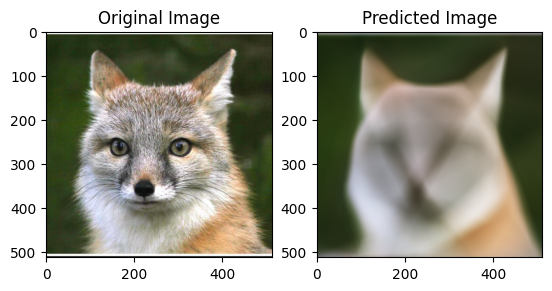

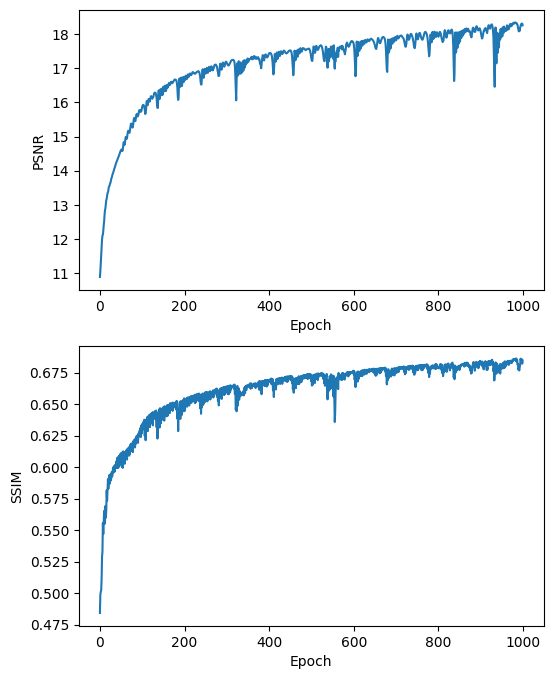

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_man)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()

# Repeat for butterfly image

## Load Data

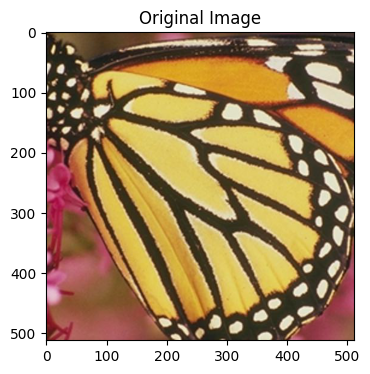

In [ ]:
image_butterfly = plt.imread('data/image/butterfly.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Original Image')
plt.show()

## Prepare input and output data

In [ ]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
X = torch.from_numpy(X) # to tensor

## Output labels
y = image_man.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Define network

In [ ]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

## Train and Test

In [ ]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=2, output_dim=y.shape[-1]).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-34-4ed5105f11f7>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-34-4ed5105f11f7>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)


Epoch [1/1000], Loss: 0.0760, PSNR: 11.1891, SSIM: 0.5194
Epoch [2/1000], Loss: 0.0600, PSNR: 12.2157, SSIM: 0.5457
Epoch [3/1000], Loss: 0.0683, PSNR: 11.6559, SSIM: 0.5395
Epoch [4/1000], Loss: 0.0624, PSNR: 12.0480, SSIM: 0.5481
Epoch [5/1000], Loss: 0.0598, PSNR: 12.2307, SSIM: 0.5496
Epoch [6/1000], Loss: 0.0603, PSNR: 12.1944, SSIM: 0.5437
Epoch [7/1000], Loss: 0.0608, PSNR: 12.1575, SSIM: 0.5412
Epoch [8/1000], Loss: 0.0601, PSNR: 12.2083, SSIM: 0.5426
Epoch [9/1000], Loss: 0.0589, PSNR: 12.3001, SSIM: 0.5465
Epoch [10/1000], Loss: 0.0580, PSNR: 12.3653, SSIM: 0.5511
Epoch [11/1000], Loss: 0.0578, PSNR: 12.3824, SSIM: 0.5544
Epoch [12/1000], Loss: 0.0578, PSNR: 12.3834, SSIM: 0.5556
Epoch [13/1000], Loss: 0.0576, PSNR: 12.3954, SSIM: 0.5560
Epoch [14/1000], Loss: 0.0572, PSNR: 12.4262, SSIM: 0.5563
Epoch [15/1000], Loss: 0.0566, PSNR: 12.4681, SSIM: 0.5560
Epoch [16/1000], Loss: 0.0561, PSNR: 12.5073, SSIM: 0.5549
Epoch [17/1000], Loss: 0.0559, PSNR: 12.5275, SSIM: 0.5538
Epoch 

## Show Results

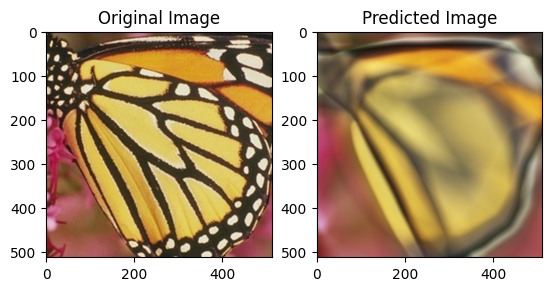

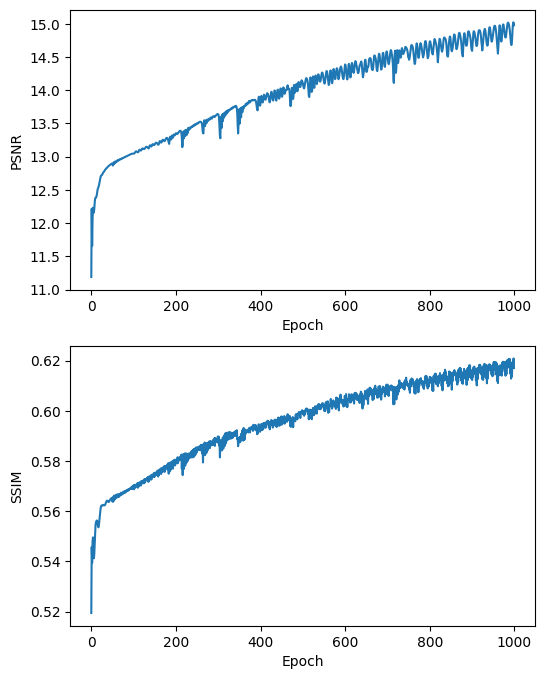

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_man)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()

# Repeat for cameraman image

## Load Data

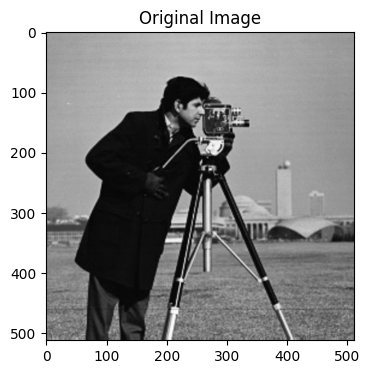

In [ ]:
image_man = plt.imread('data/image/cameraman.jpg')/255.0
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Original Image')
plt.show()

## Prepare input and output data

In [ ]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
X = torch.from_numpy(X) # to tensor

## Output labels
y = image_man.reshape(-1, image_man.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Define network

In [ ]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

## Train and Test

In [ ]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=2, output_dim=y.shape[-1]).to(device)

## Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

## Train the model
num_epochs = 100
num_samples = X.shape[0]
psnr_list = []
ssim_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)
  loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  psnr = peak_signal_noise_ratio(image_man, image_pred)
  ssim = structural_similarity(image_man, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-39-82fc2facf40a>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_man, image_pred)
<ipython-input-39-82fc2facf40a>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_man, image_pred, multichannel=True)


Epoch [1/100], Loss: 0.0598, PSNR: 12.2364, SSIM: 0.6145
Epoch [2/100], Loss: 0.0581, PSNR: 12.3571, SSIM: 0.6050
Epoch [3/100], Loss: 0.0547, PSNR: 12.6207, SSIM: 0.6169
Epoch [4/100], Loss: 0.0513, PSNR: 12.8952, SSIM: 0.6215
Epoch [5/100], Loss: 0.0485, PSNR: 13.1425, SSIM: 0.6190
Epoch [6/100], Loss: 0.0472, PSNR: 13.2576, SSIM: 0.6231
Epoch [7/100], Loss: 0.0470, PSNR: 13.2798, SSIM: 0.6228
Epoch [8/100], Loss: 0.0467, PSNR: 13.3072, SSIM: 0.6215
Epoch [9/100], Loss: 0.0458, PSNR: 13.3901, SSIM: 0.6255
Epoch [10/100], Loss: 0.0445, PSNR: 13.5167, SSIM: 0.6256
Epoch [11/100], Loss: 0.0439, PSNR: 13.5706, SSIM: 0.6258
Epoch [12/100], Loss: 0.0435, PSNR: 13.6118, SSIM: 0.6278
Epoch [13/100], Loss: 0.0427, PSNR: 13.6979, SSIM: 0.6280
Epoch [14/100], Loss: 0.0417, PSNR: 13.8028, SSIM: 0.6282
Epoch [15/100], Loss: 0.0406, PSNR: 13.9131, SSIM: 0.6305
Epoch [16/100], Loss: 0.0396, PSNR: 14.0197, SSIM: 0.6313
Epoch [17/100], Loss: 0.0386, PSNR: 14.1299, SSIM: 0.6323
Epoch [18/100], Loss: 0

## Show Results

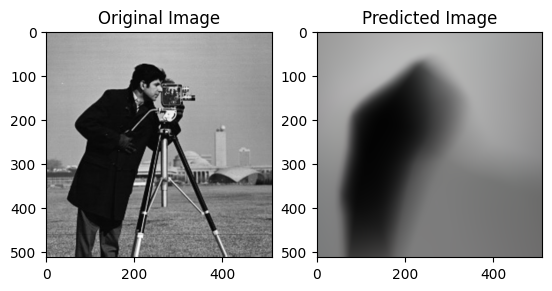

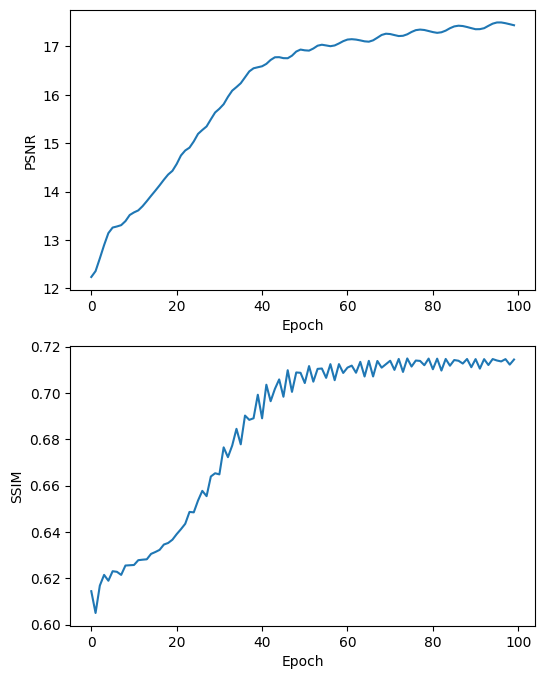

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_man)
ax[0].set_title('Original Image')
ax[1].imshow(image_pred)
ax[1].set_title('Predicted Image')
plt.show()

# Plot PSNR and SSIM against ground truth as a function of epochs
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
ax[0].plot(psnr_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('PSNR')
ax[1].plot(ssim_list)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('SSIM')
plt.show()